In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras 
from keras.layers import Input, Dense, Dropout, LSTM
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

In [2]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, history, label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [4]:
df = pd.read_csv("../data/data_processed_cleaned.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')

df['fve'] = df['fve'] * 0.03
df['mve'] = df['mve'] * 0.07
df['wpg'] = df['wpg'] * 0.07

df['production_usage'] = df['fve'] + df['mve'] + df['wpg'] 
TRAIN_SPLIT = 29000

In [5]:
features_considered = ['price', 'isWeekend', 'isHoliday','temp', 'wind', 'day_cos', 'day_sin', 'month_cos', 'month_sin']
features = df[features_considered]
features.index = df['date']

prod_dataset = df['production_usage'].values
data_mean = prod_dataset.mean(axis=0)
data_std = prod_dataset.std(axis=0)
prod_dataset = (prod_dataset-data_mean)/data_std


cons_dataset = df['consumption_usage'].values
data_mean = cons_dataset.mean(axis=0)
data_std = cons_dataset.std(axis=0)
cons_dataset = (cons_dataset-data_mean)/data_std

dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

In [6]:
past_history = 96
future_target = 4
STEP = 1


x, y1 = multivariate_data(dataset, prod_dataset, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x, y2 = multivariate_data(dataset, cons_dataset, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val , y1_val = multivariate_data(dataset, prod_dataset,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
x_val , y2_val = multivariate_data(dataset, cons_dataset,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [74]:
# https://stackoverflow.com/questions/47596703/multiple-outputs-for-multi-step-ahead-time-series-prediction-with-keras-lstm

inputs = Input(shape=(past_history,len(features_considered))) 
m = LSTM(64,  return_sequences=True)(inputs)
m = Dropout(0.2)(m)
m = LSTM(128)(m)
m = Dropout(0.1)(m)
outputA = Dense(future_target, activation='tanh')(m)
outputB = Dense(future_target, activation='tanh')(m)

m = Model(inputs=[inputs], outputs=[outputA, outputB])
m.compile(optimizer='adam', loss='mse')


history = m.fit(x,[y1,y2], epochs=10,steps_per_epoch=100)

test_scores = m.evaluate(x_val, [y1_val, y2_val], verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/10


ValueError: in user code:

    File "/Users/williambrach/miniforge3/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/williambrach/miniforge3/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/williambrach/miniforge3/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/williambrach/miniforge3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/williambrach/miniforge3/lib/python3.8/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/Users/williambrach/miniforge3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 184, in __call__
        self.build(y_pred)
    File "/Users/williambrach/miniforge3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 133, in build
        self._losses = tf.nest.map_structure(self._get_loss_object, self._losses)
    File "/Users/williambrach/miniforge3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 272, in _get_loss_object
        loss = losses_mod.get(loss)
    File "/Users/williambrach/miniforge3/lib/python3.8/site-packages/keras/losses.py", line 2369, in get
        return deserialize(identifier)
    File "/Users/williambrach/miniforge3/lib/python3.8/site-packages/keras/losses.py", line 2324, in deserialize
        return deserialize_keras_object(
    File "/Users/williambrach/miniforge3/lib/python3.8/site-packages/keras/utils/generic_utils.py", line 709, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown loss function: rmse. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


In [72]:
pred = m.predict(x_val)

In [69]:
x_val[0][1]

array([-1.33736459, -0.62700061, -0.20701967, -0.70094085, -0.62389361,
        1.22474487,  0.70710678, -1.338265  , -0.45076617])

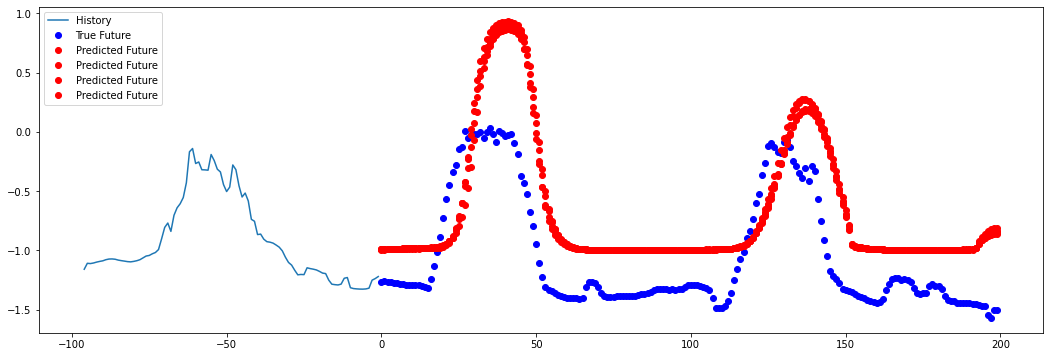

In [60]:
multi_step_plot(prod_dataset[TRAIN_SPLIT:][:96], y1_val[:200], pred[0][:200])

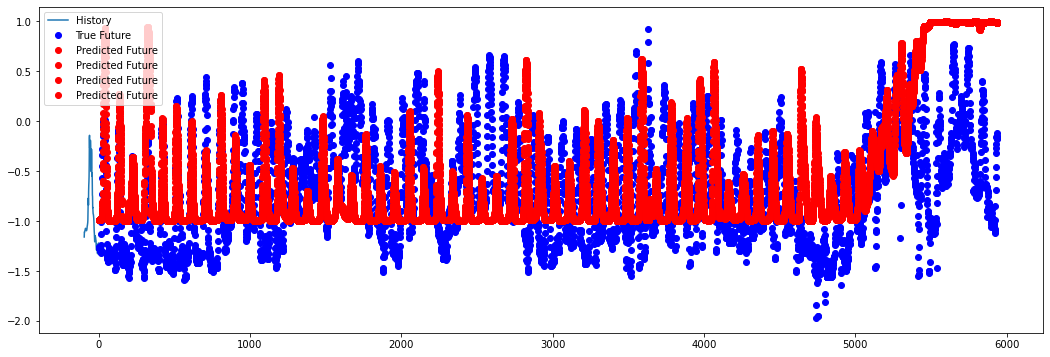

In [61]:
multi_step_plot(prod_dataset[TRAIN_SPLIT:][:96], y1_val, pred[0])

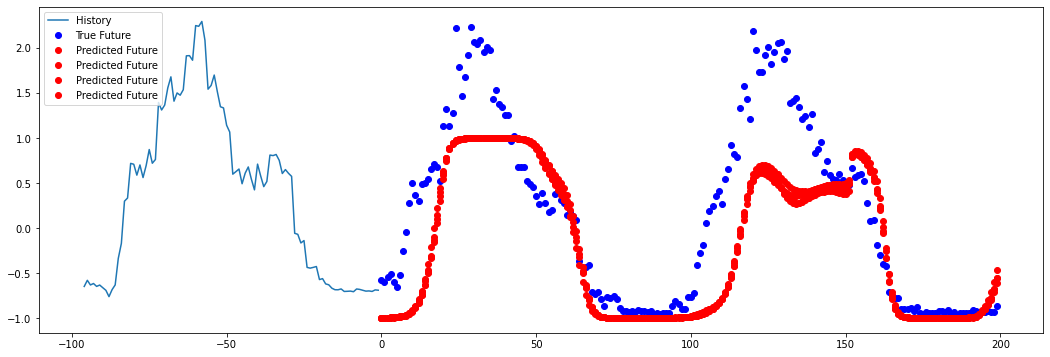

In [62]:
multi_step_plot(cons_dataset[TRAIN_SPLIT:][:96], y2_val[:200], pred[1][:200])

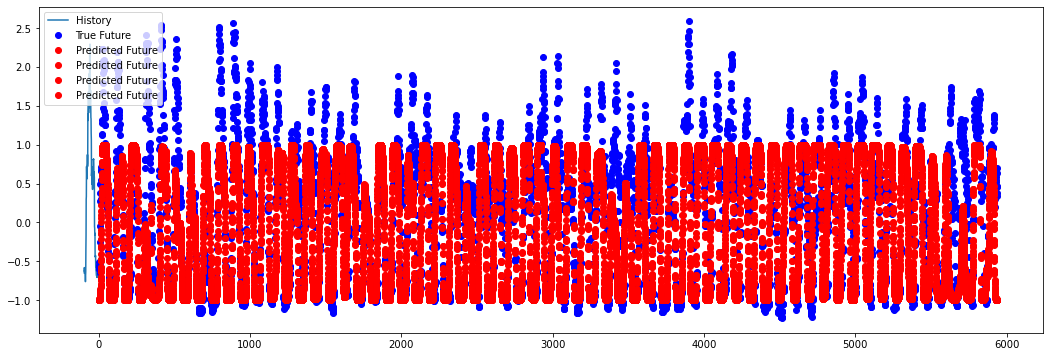

In [63]:
multi_step_plot(cons_dataset[TRAIN_SPLIT:][:96], y2_val, pred[1])